In [4]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.pipeline import make_pipeline
import os

#skimage
import  skimage
import skimage.color
import skimage.feature
import skimage.transform
import skimage.io

In [3]:
from sklearn.base import BaseEstimator , TransformerMixin

class rgb2gray_transform(BaseEstimator, TransformerMixin):
    import skimage.color
    
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return np.array([skimage.color.rgb2gray(x) for x in X])
        
class hogtransformer(BaseEstimator, TransformerMixin):
    import skimage.feature
    def __init__(self,orientations=9,pixels_per_cell=(8,8),cells_per_block=(3,3)):
        self.orientations =  orientations
        self.pixel_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        def local_hog(img):
            hog_features = skimage.feature.hog(img, orientations= self.orientations,
                                pixels_per_cell = self.pixel_per_cell,
                                cells_per_block = self.cells_per_block)
            return hog_features
        
        hfeatures = np.array([local_hog(x) for x in X])
        return hfeatures
                    

In [14]:
#make pipeline model
import matplotlib.pyplot as plt
image = skimage.io.imread('eagle.jpg')
#transform iimg to 80 X 80
image_resize= skimage.transform.resize(image,(80,80))
image_scale = 255*image_resize
image_transform = image_scale.astype(np.uint8)

#rgb to gray
gray = skimage.color.rgb2gray(image_transform)
#hog transform
feature_vector =skimage.feature.hog(gray, orientations=10,pixels_per_cell=(8,8),cells_per_block=(2,2))
feature_vector


array([0.20979654, 0.02552764, 0.25555313, ..., 0.04803068, 0.0377739 ,
       0.00724294])

In [17]:
import pickle
#load the model
model = pickle.load(open('dsa_image_classification_sgd.pickle','rb'))
scaler= pickle.load(open('dsa_scalar.pickle','rb'))

In [19]:
scalex= scaler.transform(feature_vector.reshape(1,-1))
result= model.predict(scalex)

In [20]:
result

array(['eagle'], dtype='<U8')

In [21]:
#cal the probabiity
decision_value = model.decision_function(scalex)

In [22]:
decision_value

array([[-163.54726859, -168.10910308, -145.18852946, -186.71857574,
        -218.88659592, -212.33645044,  -29.75357312,  -19.5497197 ,
        -282.53776899, -169.61678066, -236.78661547,  -49.91828152,
        -231.62141048, -209.30530528,  -86.98009175, -102.4916078 ,
        -161.15185245, -158.62766999, -176.29080075, -330.10802889]])

In [26]:
labels= model.classes_

In [24]:
decision_value= decision_value.flatten()

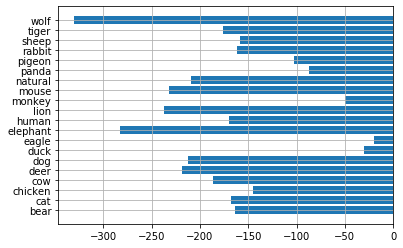

In [29]:
plt.barh(labels, decision_value)
plt.grid()

In [31]:
#cal zscore
z = scipy.stats.zscore(decision_value)
prob_value = scipy.special.softmax(z)
prob_value

array([0.03162734, 0.02982911, 0.04002887, 0.02349267, 0.01554764,
       0.01691093, 0.17606619, 0.20069686, 0.00686982, 0.02925757,
       0.01235692, 0.13592549, 0.01320369, 0.01758165, 0.08448132,
       0.06923365, 0.0326146 , 0.03368829, 0.02685622, 0.00373116])

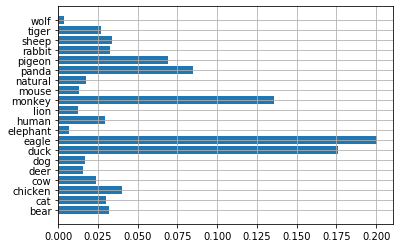

In [32]:
plt.barh(labels, prob_value)
plt.grid()

In [35]:
#top 5 prob values
top_5_prob_index = prob_value.argsort()[::-1][:5]

In [37]:
top_labels= labels[top_5_prob_index]
top_prob = prob_value[top_5_prob_index]

In [38]:
top_prob,top_labels

(array([0.20069686, 0.17606619, 0.13592549, 0.08448132, 0.06923365]),
 array(['eagle', 'duck', 'monkey', 'panda', 'pigeon'], dtype='<U8'))

In [40]:
top_dict= dict()
for key,val in zip(top_labels,top_prob):
    top_dict.update({key:np.round(val,2)})
    

In [41]:
top_dict

{'eagle': 0.2, 'duck': 0.18, 'monkey': 0.14, 'panda': 0.08, 'pigeon': 0.07}

In [44]:
def pipeline_model(path, scaler_transform,model_sgd):
    import matplotlib.pyplot as plt
    image = skimage.io.imread('eagle.jpg')
#transform iimg to 80 X 80
    image_resize= skimage.transform.resize(image,(80,80))
    image_scale = 255*image_resize
    image_transform = image_scale.astype(np.uint8)

    #rgb to gray
    gray = skimage.color.rgb2gray(image_transform)
    #hog transform
    feature_vector =skimage.feature.hog(gray, orientations=10,pixels_per_cell=(8,8),cells_per_block=(2,2))
    feature_vector
    #scaling
    scalex = scaler_transform.transform(feature_vector.reshape(1,-1))
    result = model_sgd.predict(scalex)
    #decision function
    decision_value = model.decision_function(scalex).flatten()
    labels =model_sgd.classes_
    #probability
    z = scipy.stats.zscore(decision_value)
    prob_value = scipy.special.softmax(z)
    prob_value
    #top 5
    top_5_prob_index = prob_value.argsort()[::-1][:5]
    top_labels= labels[top_5_prob_index]
    top_prob = prob_value[top_5_prob_index]
    #put it in the dict
    top_dict= dict()
    for key,val in zip(top_labels,top_prob):
        top_dict.update({key:np.round(val,2)})
    
    
    return top_dict

In [45]:
res = pipeline_model('eagle.jpg',scaler,model)
res

{'eagle': 0.2, 'duck': 0.18, 'monkey': 0.14, 'panda': 0.08, 'pigeon': 0.07}